In [1]:
!which python

/Users/alelevier/Documents/github/ssdmultibox/venv/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cpu')

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-3

criterion = SSDLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
current_time = time.time()

In [8]:
NUM_WORKERS = utils.get_cpu_count()

if platform.system() == 'Darwin': # Mac
    BATCH = 4
    SHUFFLE = False
else:
    BATCH = 32
    SHUFFLE = True

train_dataset = TrainPascalFlatDataset()
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE)

In [9]:
EPOCHS = 4

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for i in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if i % 5 == 0:
            print('step: {} loss: {:.4f} time: {:.4f}'.format(i, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())
        break
    break

pos_loss: 112.7404 neg_hard_mining_loss: 353.1814
n: 37.0 bbs_loss: 2721.0784 cats_loss: 465.9217
step: 0 loss: 86.1351 time: 6.9284



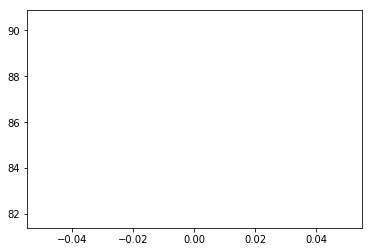

In [10]:
plt.plot(losses['total'])

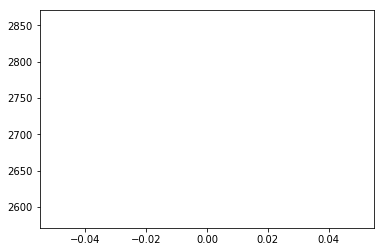

In [11]:
plt.plot(losses['loc'])

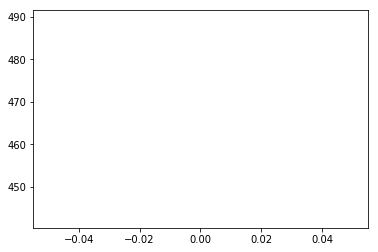

In [12]:
plt.plot(losses['conf'])

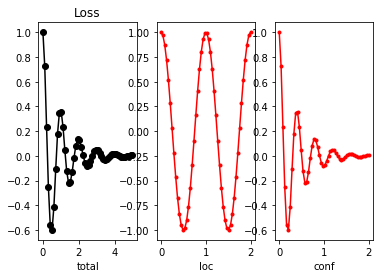

In [13]:
import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(1, 3, 1)
plt.plot(x1, y1, 'ko-')
plt.title('Loss')
plt.xlabel('total')

plt.subplot(1, 3, 2)
plt.plot(x2, y2, 'r.-')
plt.xlabel('loc')

plt.subplot(1, 3, 3)
plt.plot(x2, y1, 'r.-')
plt.xlabel('conf')


plt.show()

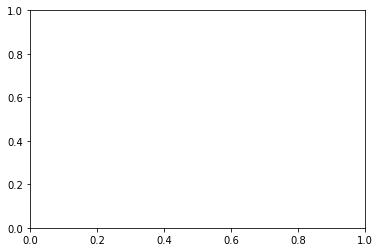

In [14]:
plt.subplot()